German Traffic Sign Recognition Benchmark (GTSRB)
=================================================
---
Introduction au Deep Learning  (IDLE) - S. Aria, E. Maldonado, JL. Parouty - CNRS/SARI/DEVLOG - 2020

## Episode 1 : Preparation of data

 - Understanding the dataset
 - Preparing and formatting data
 - Organize and backup data


## 1/ Import and init

In [1]:
import os, time, sys
import csv
import math, random

import numpy as np
import matplotlib.pyplot as plt
import PIL

from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank
from skimage import exposure

import idle.pwk as ooo

ooo.init()

IDLE 2020 - Practical Work Module
  Version            : 0.1.1
  Run time           : Saturday 4 January 2020, 17:23:27
  Matplotlib style   : idle/talk.mplstyle
  TensorFlow version :  2.0.0
  Keras version      :  2.2.4-tf


## 2/ Read the dataset
Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset
 - Each directory contains one CSV file with annotations ("GT-<ClassID>.csv") and the training images
 - First line is fieldnames: Filename;Width;Height;Roi.X1;Roi.Y1;Roi.X2;Roi.Y2;ClassId  
    
### 2.1/ Usefull functions

In [2]:
def read_dataset_dir(csv_filename):
    '''Reads traffic sign data from German Traffic Sign Recognition Benchmark dataset.

    Arguments:  csv filename
                Example /data/GTSRB/Train.csv
    Returns:   list of images, list of corresponding labels'''

    # ---- csv filename and path
    #
    name=os.path.basename(csv_filename)
    path=os.path.dirname(csv_filename)
    
    # ---- Read csv file
    #
    f,x,y = [],[],[]
    with open(csv_filename) as csv_file:
        reader = csv.DictReader(csv_file, delimiter=',')
        for row in reader:
            f.append( path+'/'+row['Path'] )
            y.append( int(row['ClassId'])  )
        csv_file.close()
    nb_images = len(f)

    # ---- Read images
    #
    for filename in f:
        image   = PIL.Image.open( filename )
        image.load()
        x.append(image)
        ooo.update_progress(name,len(x),nb_images)

    # ---- Return
    return x,y

### 2.2 Read the data
We will read the following datasets:
 - **x_train, y_train** : Learning data
 - **x_test, y_test** : Validation or test data
 - x_meta, y_meta : Illustration data
 
The learning data will be randomly mixted and the illustration data sorted.

In [3]:
%%time

# ---- Read datasets
(x_train,y_train) = read_dataset_dir('./data/origine/Train.csv') #  , 39209)
(x_test ,y_test)  = read_dataset_dir('./data/origine/Test.csv')  #  ,  12630)
(x_meta ,y_meta)  = read_dataset_dir('./data/origine/Meta.csv')  #  ,  43)
    
# ---- Shuffle train set
combined = list(zip(x_train,y_train))
random.shuffle(combined)
x_train,y_train = zip(*combined)

# ---- Sort Meta
combined = list(zip(x_meta,y_meta))
combined.sort(key=lambda x: x[1])
x_meta,y_meta = zip(*combined)

Train.csv        [########################################] 100.0% of 39209
Test.csv         [########################################] 100.0% of 12630
Meta.csv         [########################################] 100.0% of 43
CPU times: user 9.39 s, sys: 9.77 s, total: 19.2 s
Wall time: 19.3 s


## 3/ Few statistics about train dataset
We want to know if our images are homogeneous in terms of size, ratio, width or height.

### 3.1 Do statistics 

In [4]:
train_size  = []
train_ratio = []
train_lx    = []
train_ly    = []

test_size   = []
test_ratio  = []
test_lx     = []
test_ly     = []

for image in x_train:
    (lx,ly) = image.size
    train_size.append(lx*ly/1024)
    train_ratio.append(lx/ly)
    train_lx.append(lx)
    train_ly.append(ly)

for image in x_test:
    (lx,ly) = image.size
    test_size.append(lx*ly/1024)
    test_ratio.append(lx/ly)
    test_lx.append(lx)
    test_ly.append(ly)

### 3.2 Show it

x_train size :  39209
y_train size :  39209
x_test size  :  12630
y_test size  :  12630


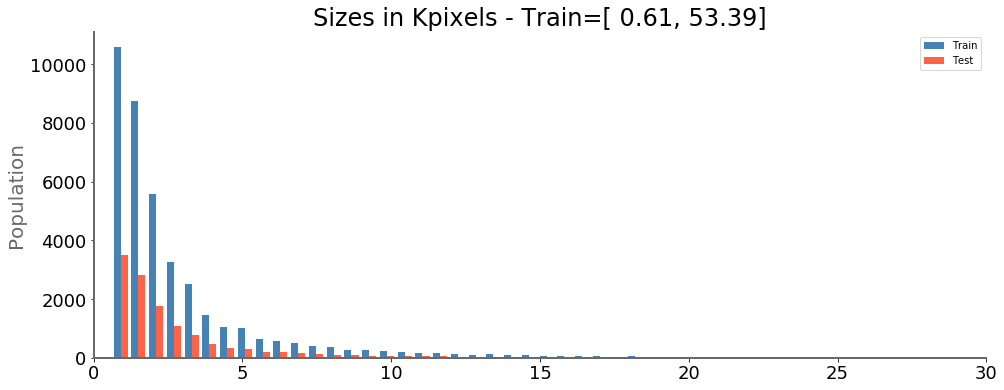

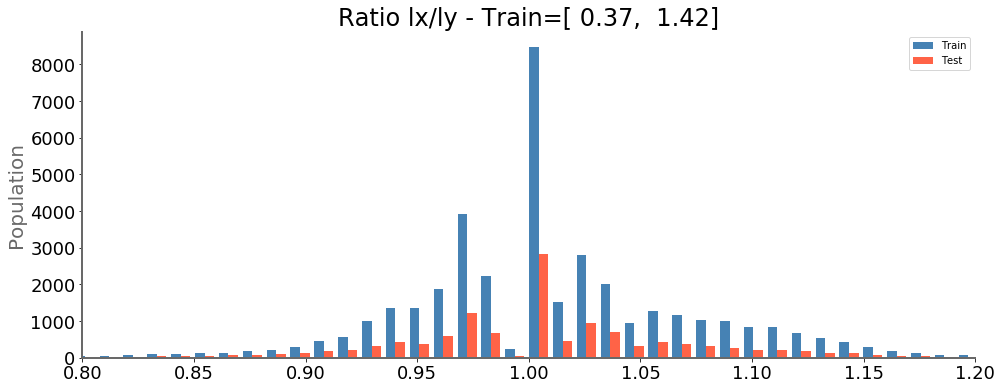

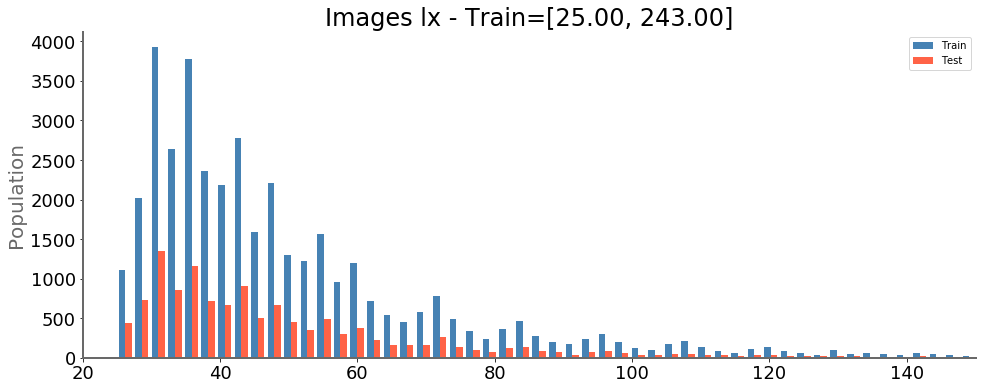

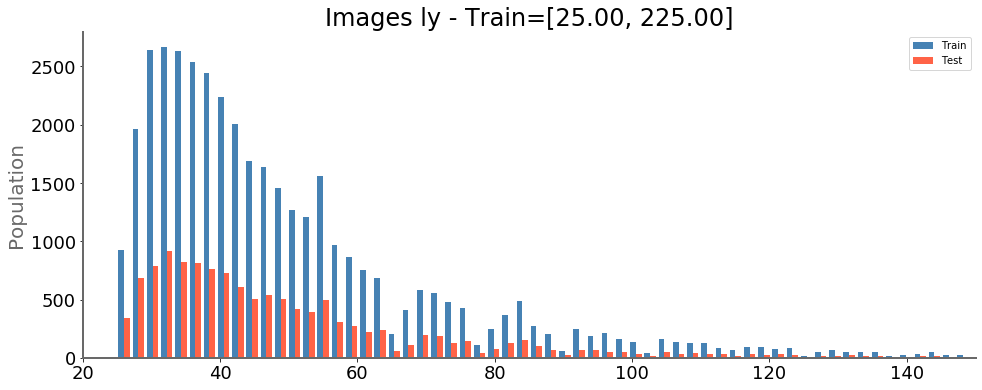

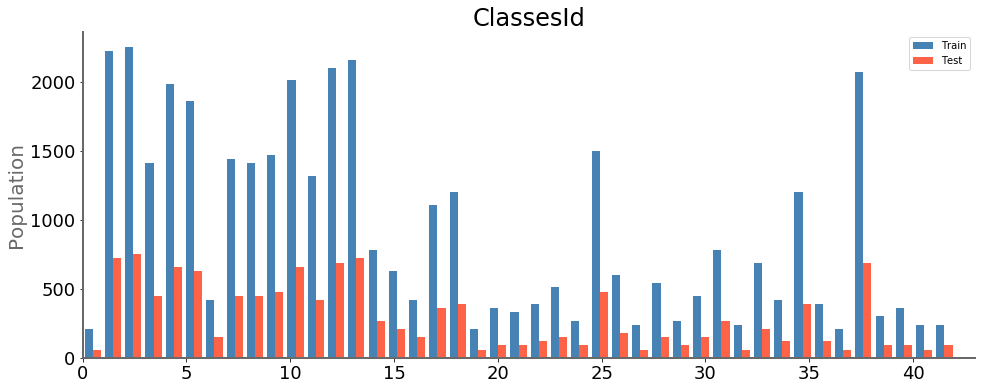

In [5]:
# ------ Global stuff
print("x_train size : ",len(x_train))
print("y_train size : ",len(y_train))
print("x_test size  : ",len(x_test))
print("y_test size  : ",len(y_test))

# ------ Statistics / sizes
plt.figure(figsize=(16,6))
plt.hist([train_size,test_size], bins=100)
plt.gca().set(title='Sizes in Kpixels - Train=[{:5.2f}, {:5.2f}]'.format(min(train_size),max(train_size)), 
              ylabel='Population',
              xlim=[0,30])
plt.legend(['Train','Test'])
plt.show()

# ------ Statistics / ratio lx/ly
plt.figure(figsize=(16,6))
plt.hist([train_ratio,test_ratio], bins=100)
plt.gca().set(title='Ratio lx/ly - Train=[{:5.2f}, {:5.2f}]'.format(min(train_ratio),max(train_ratio)), 
              ylabel='Population',
              xlim=[0.8,1.2])
plt.legend(['Train','Test'])
plt.show()

# ------ Statistics / lx
plt.figure(figsize=(16,6))
plt.hist([train_lx,test_lx], bins=100)
plt.gca().set(title='Images lx - Train=[{:5.2f}, {:5.2f}]'.format(min(train_lx),max(train_lx)), 
              ylabel='Population',
              xlim=[20,150])
plt.legend(['Train','Test'])
plt.show()

# ------ Statistics / ly
plt.figure(figsize=(16,6))
plt.hist([train_ly,test_ly], bins=100)
plt.gca().set(title='Images ly - Train=[{:5.2f}, {:5.2f}]'.format(min(train_ly),max(train_ly)), 
              ylabel='Population',
              xlim=[20,150])
plt.legend(['Train','Test'])
plt.show()

# ------ Statistics / classId
plt.figure(figsize=(16,6))
plt.hist([y_train,y_test], bins=43)
plt.gca().set(title='ClassesId', 
              ylabel='Population',
              xlim=[0,43])
plt.legend(['Train','Test'])
plt.show()

## 4/ List of classes
What are the 43 classes of our images...

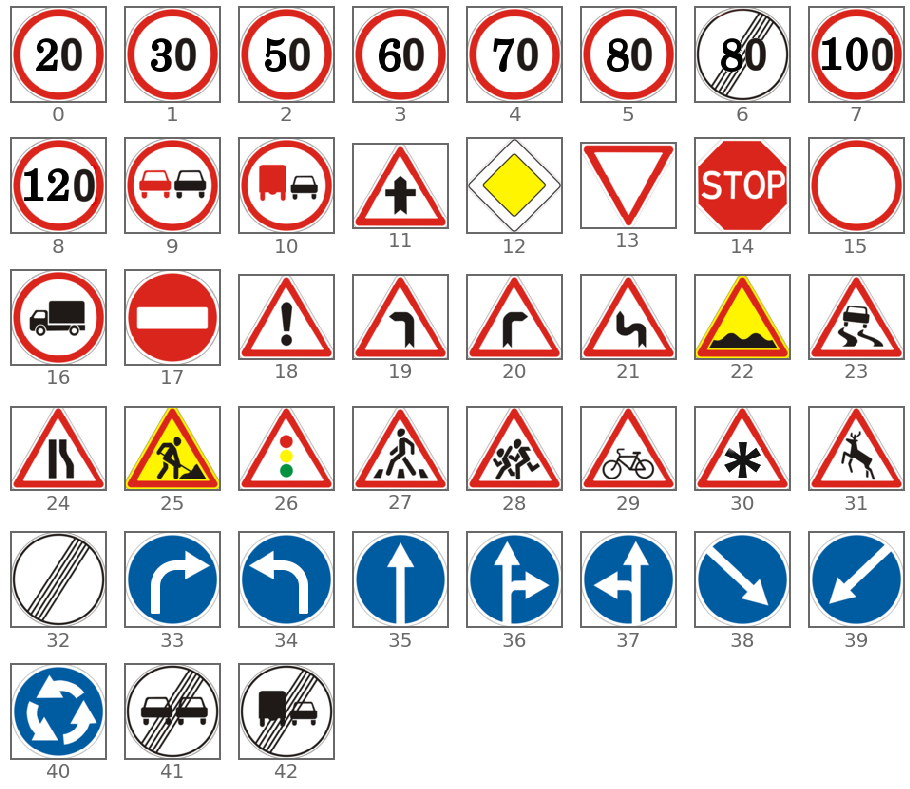

In [6]:
ooo.plot_images(x_meta,y_meta, range(43), columns=8, x_size=2, y_size=2, 
                                colorbar=False, y_pred=None, cm='binary')

## 5/ What does it really look like

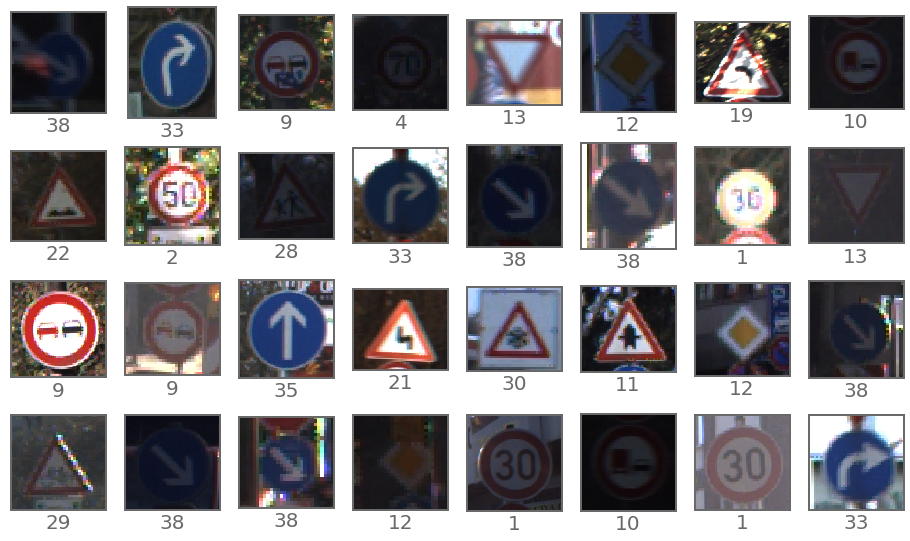

In [7]:
# ---- Get and show few images

samples = [ random.randint(0,len(x_train)-1) for i in range(32)]
ooo.plot_images(x_train,y_train, samples, columns=8, x_size=2, y_size=2, colorbar=False, y_pred=None, cm='binary')


## 6/ dataset cooking...

Images must have the **same size** to match the size of the network.   
It is possible to work on **rgb** or **monochrome** images and **equalize** the histograms.   
The data must be **normalized**.  

See : [Exposure with scikit-image](https://scikit-image.org/docs/dev/api/skimage.exposure.html)  
See : [Local histogram equalization](https://scikit-image.org/docs/dev/api/skimage.filters.rank.html#skimage.filters.rank.equalize)  
See : [Histogram equalization](https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist)  

In [8]:
def images_enhancement(images, width=25, height=25, mode='RGB'):
    '''
    Resize and convert images - doesn't change originals
    args:
        images :         images list
        width,height :   new images size (25,25)
        mode :           RGB | L | HE | LHE | CLAHE
    return:
        enhanced images : new images as a list of list
    '''
    
    out=[]
    for image in images:
        
        # ---- Resize anyway
        image=image.resize( (width,height), resample=PIL.Image.LANCZOS)
               
        # ---- if not RGB, convert image to grayscale
        if mode!='RGB':
            image=image.convert('L')

        # ---- convert image to numpy
        npi=np.array(image)
        
        # ---- Histogram Equalization
        if mode=='HE':
            npi=exposure.equalize_hist(npi)
            
        # ---- Local Histogram Equalization
        if mode=='LHE':
            npi=rank.equalize(npi, disk(10))
        
        # ---- Contrast Limited Adaptive Histogram Equalization (CLAHE)
        if mode=='CLAHE':
            npi=exposure.equalize_adapthist(npi)
            
        # ---- Normalize
        npi=(npi / 255.).astype(np.float32)
        
        # ---- Add image in list of list
        out.append(npi.tolist())
        ooo.update_progress('Enhancement: ',len(out),len(images))
    return out

### 6.1/ To get an idea of the different recipes

Enhancement:     [########################################] 100.0% of 50
Enhancement:     [########################################] 100.0% of 50
Enhancement:     [########################################] 100.0% of 50
Enhancement:     [########################################] 100.0% of 50
Enhancement:     [########################################] 100.0% of 50
x_samples / original


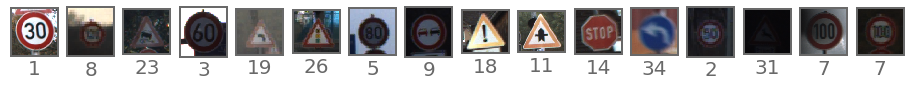

x_samples_RGB


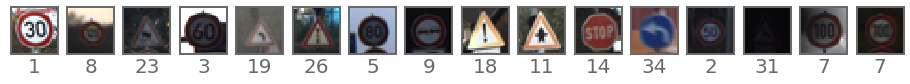

x_samples_L


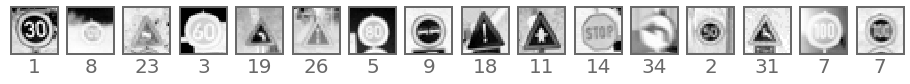

x_samples_HE


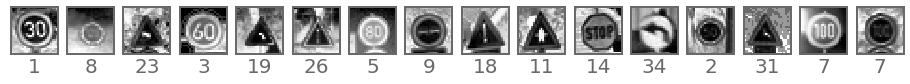

x_samples_LHE


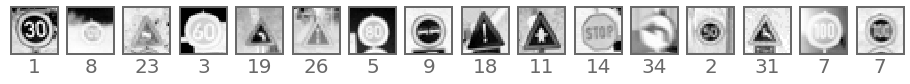

x_samples_CLAHE


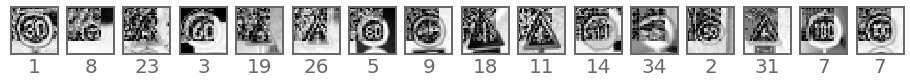

In [9]:
x_samples = x_train[:50]
samples   = range(16)

x_samples_RGB   = images_enhancement( x_samples, width=25, height=25, mode='RGB'  )
x_samples_L     = images_enhancement( x_samples, width=25, height=25, mode='L'    )
x_samples_HE    = images_enhancement( x_samples, width=25, height=25, mode='HE'   )
x_samples_LHE   = images_enhancement( x_samples, width=25, height=25, mode='LHZ'  )
x_samples_CLAHE = images_enhancement( x_samples, width=25, height=25, mode='CLAHE')

print("x_samples / original")
ooo.plot_images(x_samples,       y_train, samples, columns=16, x_size=1, y_size=1, colorbar=False, y_pred=None, cm='binary')

print("x_samples_RGB")
ooo.plot_images(x_samples_RGB,   y_train, samples, columns=16, x_size=1, y_size=1, colorbar=False, y_pred=None, cm='binary')

print("x_samples_L")
ooo.plot_images(x_samples_L,     y_train, samples, columns=16, x_size=1, y_size=1, colorbar=False, y_pred=None, cm='binary')

print("x_samples_HE")
ooo.plot_images(x_samples_HE,    y_train, samples, columns=16, x_size=1, y_size=1, colorbar=False, y_pred=None, cm='binary')

print("x_samples_LHE")
ooo.plot_images(x_samples_LHE,   y_train, samples, columns=16, x_size=1, y_size=1, colorbar=False, y_pred=None, cm='binary')

print("x_samples_CLAHE")
ooo.plot_images(x_samples_CLAHE, y_train, samples, columns=16, x_size=1, y_size=1, colorbar=False, y_pred=None, cm='binary')



### 6.2/ Cook and save
A function to save a dataset

In [10]:
def save_npy_dataset(x_train, y_train, x_test, y_test, dirname):
    
    # ---- create subdir in data
    path = './data/'+dirname
    os.makedirs(path, mode=0o750, exist_ok=True)
    
    # ---- convert list in numpy dataset
    x_train_np = np.array(x_train)
    y_train_np = np.array(y_train)
    x_test_np  = np.array(x_test)
    y_test_np  = np.array(y_test)
    
    # ---- save numpy dataset
    np.save(path+'/x_train.npy', x_train_np)
    np.save(path+'/y_train.npy', y_train_np)
    np.save(path+'/x_test.npy',  x_test_np)
    np.save(path+'/y_test.npy',  y_test_np)
    
    # ---- done
    size=ooo.get_directory_size(path)
    print('Dataset : {:24s}  shape : {:22s} size : {:6.1f} Mo   (saved)\n'.format(path, str(x_train_np.shape),size))

Create enhanced datasets, and save them...

In [11]:
# ---- Create and save dataset RGB 25x25
#
print('Prepare and save dataset : RGB25')
x_train_new = images_enhancement( x_train, width=25, height=25, mode='RGB'  )
x_test_new  = images_enhancement( x_test,  width=25, height=25, mode='RGB'  )
save_npy_dataset( x_train_new, y_train, x_test_new, y_test, 'RGB25')

# ---- Create and save dataset RGB 35x35
#
print('Prepare and save dataset : RGB35')
x_train_new = images_enhancement( x_train, width=35, height=35, mode='RGB'  )
x_test_new  = images_enhancement( x_test,  width=35, height=35, mode='RGB'  )
save_npy_dataset( x_train_new, y_train, x_test_new, y_test, 'RGB35')

# ---- Create and save dataset L 25x25
#
print('Prepare and save dataset : L25')
x_train_new = images_enhancement( x_train, width=25, height=25, mode='L'  )
x_test_new  = images_enhancement( x_test,  width=25, height=25, mode='L'  )
save_npy_dataset( x_train_new, y_train, x_test_new, y_test, 'L25')

# ---- Create and save dataset L 35x35
#
print('Prepare and save dataset : L35')
x_train_new = images_enhancement( x_train, width=35, height=35, mode='L'  )
x_test_new  = images_enhancement( x_test,  width=35, height=35, mode='L'  )
save_npy_dataset( x_train_new, y_train, x_test_new, y_test, 'L35')

x_train_new,x_test_new=0,0


Prepare and save dataset : RGB25
Enhancement:     [########################################] 100.0% of 39209
Enhancement:     [########################################] 100.0% of 12630
Dataset : ./data/RGB25              shape : (39209, 25, 25, 3)     size :  742.0 Mo   (saved)

Prepare and save dataset : RGB35
Enhancement:     [########################################] 100.0% of 39209
Enhancement:     [########################################] 100.0% of 12630
Dataset : ./data/RGB35              shape : (39209, 35, 35, 3)     size : 1453.9 Mo   (saved)

Prepare and save dataset : L25
Enhancement:     [########################################] 100.0% of 39209
Enhancement:     [########################################] 100.0% of 12630
Dataset : ./data/L25                shape : (39209, 25, 25)        size :  247.6 Mo   (saved)

Prepare and save dataset : L35
Enhancement:     [########################################] 100.0% of 39209
Enhancement:     [#####################################

## 7/ Reload data to be sure ;-)

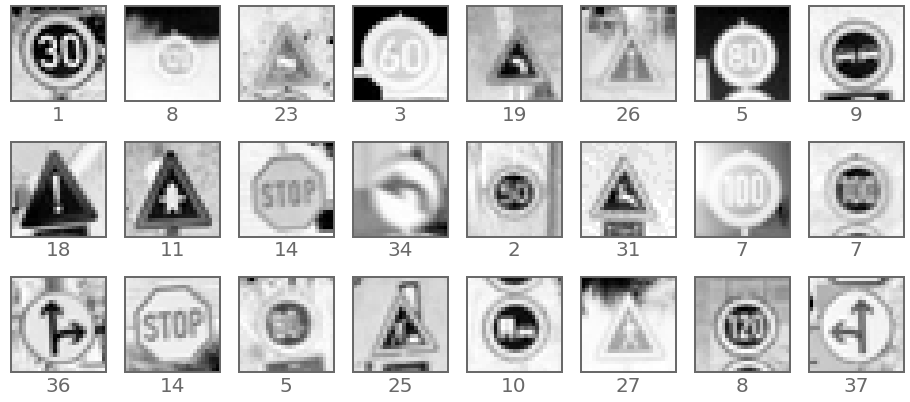

CPU times: user 766 ms, sys: 297 ms, total: 1.06 s
Wall time: 1.06 s


In [12]:
%%time

dataset='L25'
samples=range(24)

x_tmp = np.load('./data/{}/x_train.npy'.format(dataset))
y_tmp = np.load('./data/{}/y_train.npy'.format(dataset))

ooo.plot_images(x_tmp,y_tmp, samples, columns=8, x_size=2, y_size=2, colorbar=False, y_pred=None, cm='binary')
x_tmp,y_tmp=0,0

----
That's all folks !